# Gene ontology

In [3]:
import pandas as pd
import numpy as np
from glob import glob
import os
import pickle 
from biom.util import biom_open
from biom import Table, load_table
import qiime2 as q2
from skbio.stats.ordination import pcoa
from skbio.diversity import beta
from skbio.stats.distance import permanova
from skbio.stats.distance import mantel
from skbio import DistanceMatrix
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 
from skbio.diversity import beta_diversity
from collections import defaultdict

from scipy.stats import sem
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from math import log

import plotnine as pn

import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

#biom shortcuts
o="observation"
s="sample"

# Import and format

In [4]:
def save_biom(biom_filename, biom_table,author='default'):
    with biom_open(biom_filename, 'w') as f:  
            biom_table.to_hdf5(f, author)
    print("Saved to " + biom_filename)

#Import if already formatted, else: format
profile_name = "merged_functional_profile.tsv"
bt_name = "merged_functional_profile.biom"

if os.path.exists(bt_name):
    print("Loading previously saved biom table: {}".format(bt_name))
    #df = pd.read_csv(profile_name, sep='\t', index_col=0)
    bt = load_table(bt_name)
else:
    print("Making new biom table.")
    profile_list = glob("profiles/*.txt")
    out_list = []
    for p in profile_list:
        name = p.split("/")[-1].replace(".St_fprofile.txt","")
        temp_df = pd.read_csv(p, sep='\t', index_col=0)
        temp_df.columns = [name]
        out_list.append(temp_df[name])
    df = pd.DataFrame(out_list)
    df = df.fillna(0)
    df.index.name="sample_name"
    #Tanspose
    df = df.transpose()
    #Save df
    df.to_csv(profile_name, sep='\t', index_label="sample_name")
    
    #Convert to biom
    bt = Table.from_tsv(open(profile_name,'r'), None, None, lambda x:x)
    #Save biom
    save_biom(bt_name, bt)

Loading previously saved biom table: merged_functional_profile.biom


In [5]:
md=pd.read_csv("/projects/cmi_proj/seed_grants/T1D_JaneKim/11129_20200129-223118.txt", sep='\t', index_col=0)

#Filter metadata to only sampels in df and put in same order
bt_samples = set(bt.ids("sample"))
md = md.query('index.str.contains(".St")').copy()
md.index = [x.replace(".St","") for x in md.index]
md = md.query('index in @bt_samples').copy()
md = md.reindex(bt.ids("sample"))
md.index.name="sample_name"
qza_md = q2.Metadata(md)

# Make Metacyc Conversion dictionaries

In [4]:
def map_to_dict(file):
    out_dict = {}
    with open(file) as openfile:
        for line in openfile:
            linesplit = line.split()
            out_dict[linesplit[0]] = linesplit[1:]
    return(out_dict)

uniref_to_protein_dict = map_to_dict("/projects/wol/20170307/release/annotation/metacyc/protein.map")
protein_to_enzyme_dict = map_to_dict("/projects/wol/20170307/release/annotation/metacyc/protein2enzrxn.map")
enzyme_to_rxn_dict = map_to_dict("/projects/wol/20170307/release/annotation/metacyc/enzrxn2reaction.map")
rxn_to_path_dict = map_to_dict("/projects/wol/20170307/release/annotation/metacyc/reaction2pathway.map")

In [5]:
def collapse_bt_to_next_level(bt, conversion_dict):
    #Biom collapsing function
    df = pd.DataFrame(bt.to_dataframe())
    out_dict = {}
    for sample in bt.ids():
        out_dict[sample] = defaultdict(int)
    for name,row in df.iterrows():
        try:
            hits = conversion_dict[name]
        except KeyError:
            continue
        for ind in row.index:
            for hit in hits:
                out_dict[ind][hit] += row[ind]
    out_df= pd.DataFrame.from_dict(out_dict)
    out_bt = Table(data=out_df.to_numpy(), observation_ids=list(out_df.index), sample_ids=list(out_df.columns), type="OTU table")
    return(out_bt)

In [6]:
protein_bt = collapse_bt_to_next_level(bt,uniref_to_protein_dict)

In [7]:
enzyme_bt = collapse_bt_to_next_level(protein_bt,protein_to_enzyme_dict)

In [8]:
rxn_bt = collapse_bt_to_next_level(enzyme_bt,enzyme_to_rxn_dict)

In [9]:
path_bt = collapse_bt_to_next_level(rxn_bt,rxn_to_path_dict)

In [10]:
biom_dict = {"protein":protein_bt,
            "enzyme":enzyme_bt,
            "reaction":rxn_bt,
            "pathway":path_bt}

for name,table in biom_dict.items():
        print("{} features: {}".format(name, table.shape[0]))

protein features: 1006
enzyme features: 706
reaction features: 634
pathway features: 399


In [19]:
#Save pickle
pickle_file = open("pickles/metacyc_dicts.obj", 'wb') 
pickle.dump(biom_dict, pickle_file)



In [6]:
#Open pickle
biom_dict = pickle.load(open("pickles/metacyc_dicts.obj", 'rb'))

# Ordination

In [5]:
def ordination_f(bt, md=md):
    df= pd.DataFrame(bt.to_dataframe()).transpose()
    bc = beta_diversity(metric="braycurtis", counts=df.values, ids=bt.ids(s))
    pc = pcoa(distance_matrix=bc)
    return(pc)

In [6]:
ord_dict = {}
for level in biom_dict.keys():
    ord_dict[level] = ordination_f(biom_dict[level])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.13345455093771397 and the largest is 9.460298673949202.
  RuntimeWarning
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes s

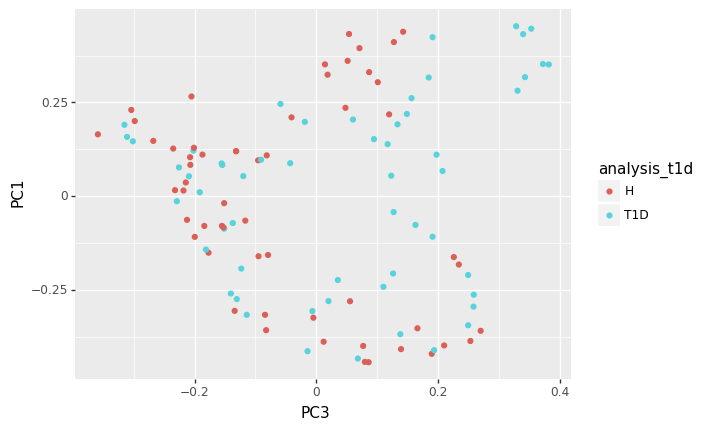

<ggplot: (8762567522154)>

In [8]:
plot_dat = ord_dict["pathway"].samples.merge(md, right_index=True, left_index=True)

p = (pn.ggplot( data=plot_dat) +
    pn.geom_point( pn.aes(x="PC3",y="PC1", color="analysis_t1d"))
    )

p

# Permanova

In [21]:
?beta_diversity

In [22]:
def permanova_f(bt, var, md=md):
    df= pd.DataFrame(bt.to_dataframe()).transpose()
    bc = beta_diversity(metric="braycurtis", counts=df.values, ids=bt.ids(s))
    perm = permanova(distance_matrix=bc, 
                     grouping=md[var], 
                     permutations=5000)
    return(perm)

In [23]:

perm_dict = {}
variables=["analysis_t1d","analysis_weight_group","analysis_disease_stage_group","fake"]

for name,bt in biom_dict.items():
    perm_dict[name] = {}
    for var in variables:
        temp_perm = permanova_f(bt, var)
        perm_dict[name][var] = temp_perm

In [24]:
temp_list = []
for name,d in perm_dict.items():
    for var in variables:
        x= d[var]
        x["variable"] = var
        x["database"] = name
        x["distance_metric"] = "bray curtis"
        x["test"] = "permanova"
        temp_list.append(x)
        
perm_df = pd.DataFrame(temp_list)
perm_df = perm_df.reset_index().loc[:,["test","database","variable","distance_metric","number of groups","test statistic","p-value"]]
perm_df.columns = ["test","database","variable","distance_metric","n groups","Pseudo-F","p-value"]
perm_df.style.bar(subset="p-value",color='#F8766D')


,test,database,variable,distance_metric,n groups,Pseudo-F,p-value
0,permanova,protein,analysis_t1d,bray curtis,2,2.10906,0.0245951
1,permanova,protein,analysis_weight_group,bray curtis,2,1.86315,0.0409918
2,permanova,protein,analysis_disease_stage_group,bray curtis,4,1.61888,0.020196
3,permanova,protein,fake,bray curtis,2,0.65988,0.827235
4,permanova,enzyme,analysis_t1d,bray curtis,2,2.68782,0.00439912
5,permanova,enzyme,analysis_weight_group,bray curtis,2,1.78678,0.0531894
6,permanova,enzyme,analysis_disease_stage_group,bray curtis,4,1.76377,0.00939812
7,permanova,enzyme,fake,bray curtis,2,0.529726,0.934013
8,permanova,reaction,analysis_t1d,bray curtis,2,2.7152,0.0059988
9,permanova,reaction,analysis_weight_group,bray curtis,2,1.83263,0.0513897


In [19]:
temp_list = []
for name,d in perm_dict.items():
    for var in variables:
        x= d[var]
        x["variable"] = var
        x["database"] = name
        x["distance_metric"] = "bray curtis"
        x["test"] = "permanova"
        temp_list.append(x)
        
perm_df = pd.DataFrame(temp_list)
perm_df = perm_df.reset_index().loc[:,["test","database","variable","distance_metric","number of groups","test statistic","p-value"]]
perm_df.columns = ["test","database","variable","distance_metric","n groups","Pseudo-F","p-value"]
perm_df.style.bar(subset="p-value",color='#F8766D')


,test,database,variable,distance_metric,n groups,Pseudo-F,p-value
0,permanova,protein,analysis_t1d,bray curtis,2,1.06596,0.288742
1,permanova,protein,analysis_weight_group,bray curtis,2,1.36354,0.116777
2,permanova,protein,analysis_disease_stage_group,bray curtis,4,1.16362,0.178564
3,permanova,protein,fake,bray curtis,2,0.783843,0.753249
4,permanova,enzyme,analysis_t1d,bray curtis,2,1.07485,0.276345
5,permanova,enzyme,analysis_weight_group,bray curtis,2,1.34053,0.120376
6,permanova,enzyme,analysis_disease_stage_group,bray curtis,4,1.09628,0.255949
7,permanova,enzyme,fake,bray curtis,2,0.758087,0.806039
8,permanova,reaction,analysis_t1d,bray curtis,2,1.14964,0.232354
9,permanova,reaction,analysis_weight_group,bray curtis,2,1.38455,0.108978


In [82]:
temp_list = []
for name,d in perm_dict.items():
    for var in variables:
        x= d[var]
        x["variable"] = var
        x["database"] = name
        x["distance_metric"] = "bray curtis"
        x["test"] = "permanova"
        temp_list.append(x)
        
perm_df = pd.DataFrame(temp_list)
perm_df = perm_df.reset_index().loc[:,["test","database","variable","distance_metric","number of groups","test statistic","p-value"]]
perm_df.columns = ["test","database","variable","distance_metric","n groups","Pseudo-F","p-value"]
perm_df.style.bar(subset="p-value",color='#F8766D')


,test,database,variable,distance_metric,n groups,Pseudo-F,p-value
0,permanova,protein,analysis_t1d,bray curtis,2,2.10906,0.0229954
1,permanova,protein,analysis_weight_group,bray curtis,2,1.86315,0.040192
2,permanova,protein,analysis_disease_stage_group,bray curtis,4,1.61888,0.0215957
3,permanova,enzyme,analysis_t1d,bray curtis,2,2.68782,0.00559888
4,permanova,enzyme,analysis_weight_group,bray curtis,2,1.78678,0.0545891
5,permanova,enzyme,analysis_disease_stage_group,bray curtis,4,1.76377,0.010198
6,permanova,reaction,analysis_t1d,bray curtis,2,2.7152,0.00639872
7,permanova,reaction,analysis_weight_group,bray curtis,2,1.83263,0.04999
8,permanova,reaction,analysis_disease_stage_group,bray curtis,4,1.79251,0.00959808
9,permanova,pathway,analysis_t1d,bray curtis,2,2.35661,0.0039992


# Random Forest

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix



In [40]:
pathway_df

,PWY0-1573,PWY0-1567,PWY0-1568,PWY-7279,PWY-7269,HOMOSER-THRESYN-PWY,PWY-5659,PWY-7456,PWY-882,PWY-3881,...,PWY-5938,PWY-7377,PWY-5837,P641-PWY,SHIKIMATEDEG-PWY,QUINATEDEG-PWY,PWY-8008,P2-PWY,PWY-5796,PWY-5389
11129.NH001.JJK,2.0,2.0,2.0,2.0,2.0,3.0,2.0,28.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11129.NH002.JJK,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11129.NH003.JJK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11129.NH004.JJK,1.0,1.0,1.0,1.0,1.0,1.0,0.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11129.NH005.JJK,33.0,33.0,33.0,33.0,33.0,31.0,42.0,31.0,42.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11129.OT1D020.JJK,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11129.OT1D021.JJK,9.0,9.0,9.0,9.0,9.0,5.0,5.0,3.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11129.OT1D022.JJK,12.0,12.0,12.0,12.0,12.0,17.0,20.0,14.0,20.0,27.0,...,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11129.OT1D023.JJK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prepare data

In [7]:
pathway_df = biom_dict["pathway"].to_dataframe().transpose().sort_index()
md = md.sort_index()
assert(all(pathway_df.index==md.index))

labels = np.array([1 if x=="T1D" else 0 for x in md.analysis_t1d])
# Saving feature names for later use
feature_list = list(pathway_df.columns)
# Convert to numpy array
features = np.array(pathway_df)

In [29]:
def rf_tuning(featrues, labels, max_estimators=175):
    # Author: Kian Ho <hui.kian.ho@gmail.com>
    #         Gilles Louppe <g.louppe@gmail.com>
    #         Andreas Mueller <amueller@ais.uni-bonn.de>
    #
    # License: BSD 3 Clause

    RANDOM_STATE = 123

    # Generate a binary classification dataset.
    X, y = featrues, labels

    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = max_estimators

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()
    
def get_importances(feature_list, rf):
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    return([('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances])

#### Protein data

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


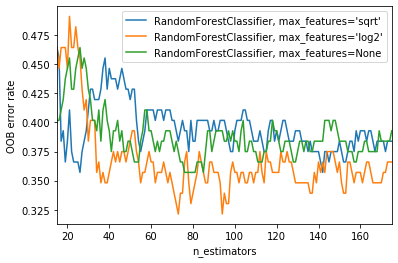

In [35]:
protein_df = biom_dict["protein"].to_dataframe().transpose().sort_index()
md = md.sort_index()
assert(all(protein_df.index==md.index))

protein_labels = np.array([1 if x=="T1D" else 0 for x in md.analysis_t1d])
# Saving feature names for later use
protein_feature_list = list(protein_df.columns)
# Convert to numpy array
protein_features = np.array(protein_df)


rf_tuning(protein_features, protein_labels, 1000)


Run RF with chosen parameters

In [31]:
protein_rf = RandomForestRegressor(n_estimators = 100, random_state = 42,warm_start=True, max_features='log2',
                               oob_score=True)
# Train the model on training data
protein_rf.fit(protein_features, protein_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=True)

Feature importances

In [32]:
protein_rf.oob_score_

-0.048547607683172345

In [33]:
get_importances(protein_feature_list, protein_rf)


['Variable: MONOMER-14262        Importance: 0.02',
 'Variable: MONOMER-19019        Importance: 0.02',
 'Variable: MONOMER-16670        Importance: 0.02',
 'Variable: MONOMER-18513        Importance: 0.01',
 'Variable: MONOMER-19928        Importance: 0.01',
 'Variable: MONOMER-13865        Importance: 0.01',
 'Variable: MONOMER-18165        Importance: 0.01',
 'Variable: MONOMER-18524        Importance: 0.01',
 'Variable: MONOMER-15684        Importance: 0.01',
 'Variable: MONOMER-182          Importance: 0.01',
 'Variable: MONOMER-183          Importance: 0.01',
 'Variable: MONOMER-2981         Importance: 0.01',
 'Variable: MONOMER-13065        Importance: 0.01',
 'Variable: MONOMER-19347        Importance: 0.01',
 'Variable: 6PGLUCONDEHYDROG-MONOMER Importance: 0.0',
 'Variable: FUM-FLAVO            Importance: 0.0',
 'Variable: GDHA-MONOMER         Importance: 0.0',
 'Variable: NADH-DHII-MONOMER    Importance: 0.0',
 'Variable: NRDA-MONOMER         Importance: 0.0',
 'Variable: M

### Pathway randomForest

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


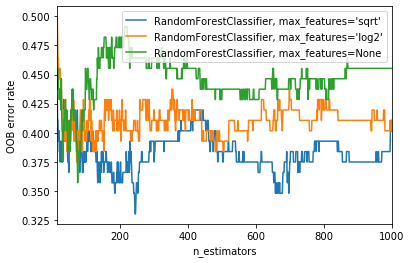

In [40]:
pathway_df = biom_dict["pathway"].to_dataframe().transpose().sort_index()
md = md.sort_index()
assert(all(pathway_df.index==md.index))

pathway_labels = np.array([1 if x=="T1D" else 0 for x in md.analysis_t1d])
# Saving feature names for later use
pathway_feature_list = list(pathway_df.columns)
# Convert to numpy array
pathway_features = np.array(pathway_df)


rf_tuning(pathway_features, pathway_labels, 1000)

In [32]:
pathway_rf = RandomForestRegressor(n_estimators = 200, random_state = 42,warm_start=True, max_features='sqrt',
                               oob_score=True)
# Train the model on training data
pathway_rf.fit(pathway_features, pathway_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=True)

In [33]:
pathway_rf.oob_score_

0.00043010388758824014

In [34]:
get_importances(pathway_feature_list, pathway_rf)

['Variable: PWY-7808             Importance: 0.1',
 'Variable: PWY-7456             Importance: 0.02',
 'Variable: PWY-6140             Importance: 0.02',
 'Variable: TRNA-CHARGING-PWY    Importance: 0.01',
 'Variable: PWY-6121             Importance: 0.01',
 'Variable: PWY-7953             Importance: 0.01',
 'Variable: PWY-7294             Importance: 0.01',
 'Variable: PWY-6317             Importance: 0.01',
 'Variable: PWY66-422            Importance: 0.01',
 'Variable: PWY-7817             Importance: 0.01',
 'Variable: PWY-5269             Importance: 0.01',
 'Variable: PWY-7991             Importance: 0.01',
 'Variable: PWY-6855             Importance: 0.01',
 'Variable: PWY-6277             Importance: 0.01',
 'Variable: PWY-6122             Importance: 0.01',
 'Variable: GLYCOCAT-PWY         Importance: 0.01',
 'Variable: PWY0-1586            Importance: 0.01',
 'Variable: LIPA-CORESYN-PWY     Importance: 0.01',
 'Variable: PWY-6708             Importance: 0.01',
 'Variable: P

In [43]:
importances = list(pathway_rf.feature_importances_)
pd.DataFrame({"feature":pathway_feature_list,"var_imp":importances})\
    .sort_values("var_imp", ascending=False)\
    .head(10)\
    .style.bar("var_imp")

,feature,var_imp
210,PWY-7808,0.0985306
325,PWY-6140,0.0202587
7,PWY-7456,0.0165292
201,PWY-6906,0.0139698
288,PWY-6517,0.0130012
168,PWY-6961,0.0123448
89,GLYCOCAT-PWY,0.00765036
248,PWY-7282,0.00755788
16,TRNA-CHARGING-PWY,0.00738897
313,PWY-7755,0.00662628


In [ ]:
pathway_rf

In [ ]:
importances = list(rf.feature_importances_)

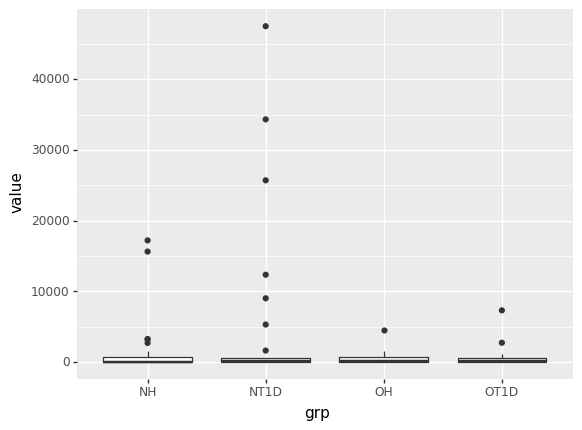

<ggplot: (8786467407396)>

In [21]:
temp = pathway_df.sum(axis=1).to_frame().join(md.loc[:,["analysis_disease_stage_group"]])
temp.columns=["value","grp"]
p = (pn.ggplot(data=temp) +
    pn.geom_boxplot( pn.aes(x="grp", y="value"))
    )
p

In [23]:
pathway_df_rel = pathway_df.apply(axis=1, func=lambda row: row/sum(row))

F_onewayResult(statistic=1.6864452031255823, pvalue=0.174220473177916)


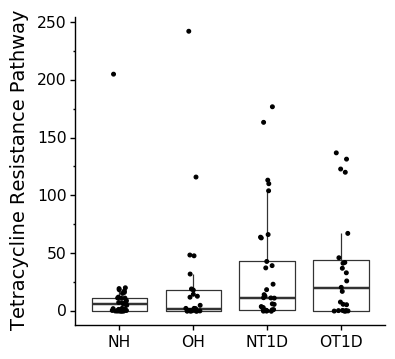

<ggplot: (8762568136042)>

In [109]:
plot_dat = pathway_df.loc[:,["PWY-7808"]].join(md.loc[:,["analysis_t1d", "analysis_disease_stage_group"]])
plot_dat = pd.DataFrame(plot_dat)
plot_dat["PWY-7808"] = [int(x) for x in plot_dat["PWY-7808"]]
pn.options.figure_size= (4,4)


make_boxplot(plot_dat, "analysis_disease_stage_group", "PWY-7808","Tetracycline Resistance Pathway")


In [33]:
plot_dat

,PWY-7808,analysis_t1d,analysis_disease_stage_group
11129.NH001.JJK,0.012757,H,NH
11129.NH002.JJK,0.256410,H,NH
11129.NH003.JJK,0.000000,H,NH
11129.NH004.JJK,0.037975,H,NH
11129.NH005.JJK,0.000128,H,NH
...,...,...,...
11129.OT1D020.JJK,0.055649,T1D,OT1D
11129.OT1D021.JJK,0.007257,T1D,OT1D
11129.OT1D022.JJK,0.000819,T1D,OT1D
11129.OT1D023.JJK,0.140351,T1D,OT1D


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


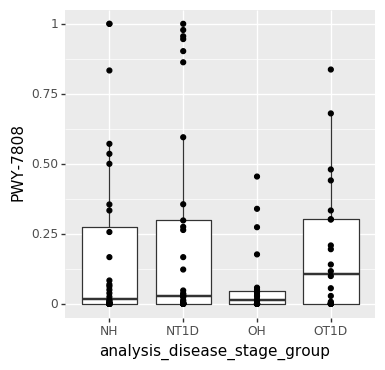

<ggplot: (8786454842800)>

In [39]:
plot_dat = pathway_df_rel.loc[:,["PWY-7808"]].join(md.loc[:,["analysis_t1d", "analysis_disease_stage_group"]])
plot_dat = pd.DataFrame(plot_dat)
plot_dat["PWY-7808"] = [float(x) for x in plot_dat["PWY-7808"]]
pn.options.figure_size= (4,4)

p = (pn.ggplot(data=plot_dat) +
    pn.geom_boxplot( pn.aes(x="analysis_disease_stage_group", y="PWY-7808"), outlier_alpha=0) +
     pn.geom_point( pn.aes(x="analysis_disease_stage_group", y="PWY-7808"))
    # pn.geom_jitter( pn.aes(x="analysis_disease_stage_group", y="PWY-7808"), width=.1)
     
    )
p

In [29]:
def make_boxplot(df, var_col, value_col, axis_label):
    grps = set(df[var_col])
    anova_values = [list(df.loc[df[var_col] == x][value_col]) for x in grps]
    print(f_oneway(*anova_values))
    #PLOT
    plot_dat = df.copy()

    plot_dat["x_axis"] = pd.Categorical(df[var_col],
                                        categories=["NH",
                                                    "OH",
                                                    "NT1D",
                                                    "OT1D"])
    p = (pn.ggplot(data = plot_dat) +
    pn.geom_boxplot( pn.aes( x="x_axis", y=value_col), outlier_alpha=0) +
     pn.geom_jitter( pn.aes(x="x_axis", y=value_col), size=1, width=.1) +
     pn.labs( x="", y=axis_label) +
     pn.theme_classic(base_size=14) +
     pn.theme(
     axis_text = pn.element_text(color="black"))
     
    )
    return(p)

# Differential abundance

In [92]:
?multinomial

In [10]:
#Set up dictionaries
dbs = ["protein","enzyme","reaction","pathway"]
factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }
songbird_dict = {db:{"t1d":{},"weight":{},"null":{}} for db in dbs}

def b2q(bt):
    return(q2.Artifact.import_data('FeatureTable[Frequency]',bt))

#Run/Import Songbird

for database in ["protein","enzyme","reaction","pathway"]:
    for factor in ["t1d","weight","null"]:
        folder = "songbird/Metacyc2/{}/{}".format(database,factor)
        if not os.path.exists(folder):
            ! mkdir -p $folder
            #Calculate Songbird
            (temp_differentials,
             temp_regression_stats,
             temp_regression_biplot) = multinomial(table=b2q(biom_dict[database]),
                                                   metadata=qza_md,
                                                   formula=factor_dict[factor],
                                                   summary_interval=1)
            #Add outputs to master dictionary
            songbird_dict[database][factor]["differentials"] = temp_differentials
            songbird_dict[database][factor]["regression_stats"] = temp_regression_stats
            songbird_dict[database][factor]["regression_biplot"] = temp_regression_biplot
            #Save outputs
            temp_differentials.save(folder + "/differentials.qza")
            temp_regression_stats.save(folder + "/regression_stats.qza")
            temp_regression_biplot.save(folder + "/regression_biplot.qza")
        else:
            songbird_dict[database][factor]["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
            songbird_dict[database][factor]["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
            songbird_dict[database][factor]["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

### Evaluate model fit

In [86]:
!ls songbird/Metacyc/pathway/t1d

differentials.qza    regression_biplot.qza
model_fit_stats.qzv  regression_stats.qza


In [91]:
?summarize_paired

t1d
weight
t1d
weight
t1d
weight
t1d
weight


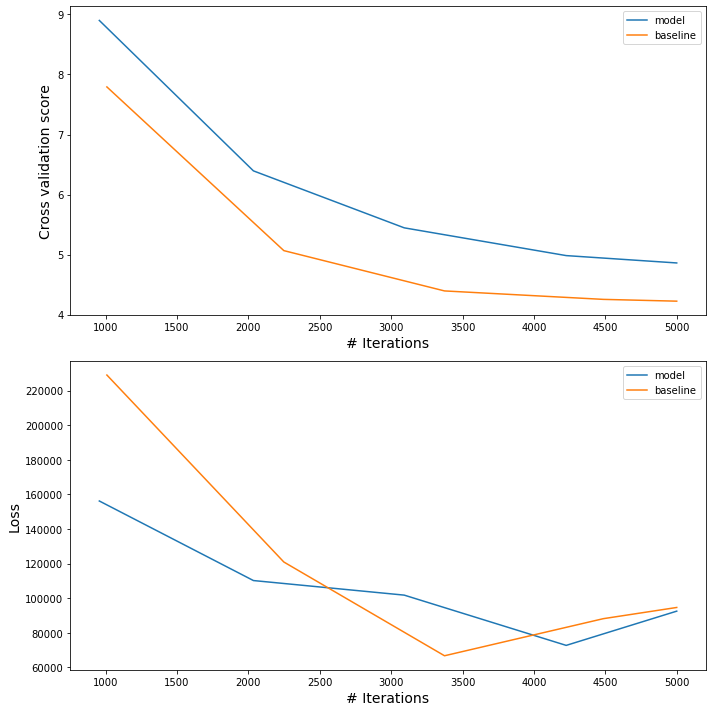

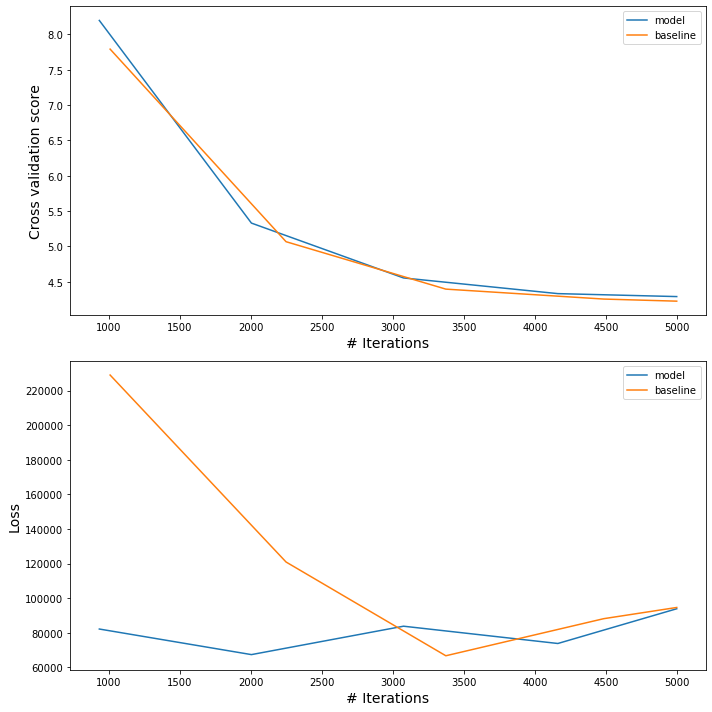

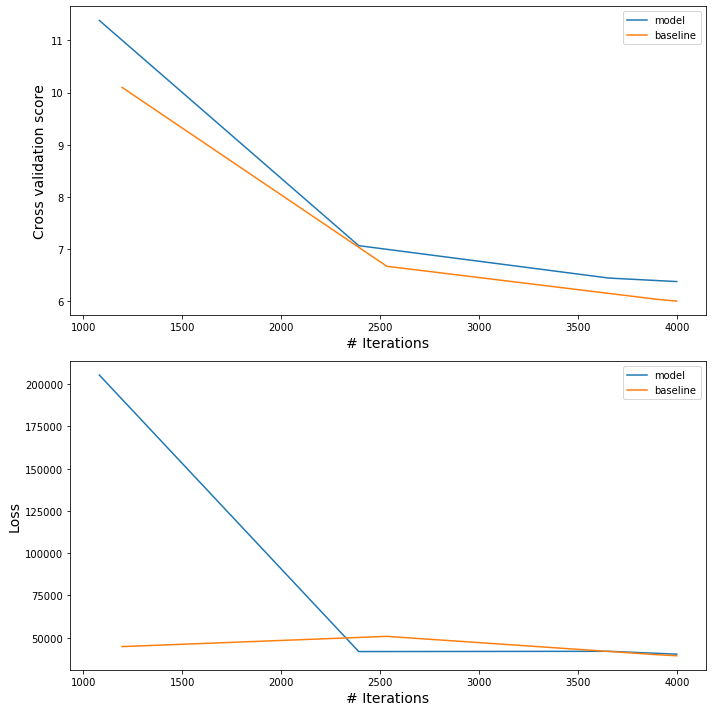

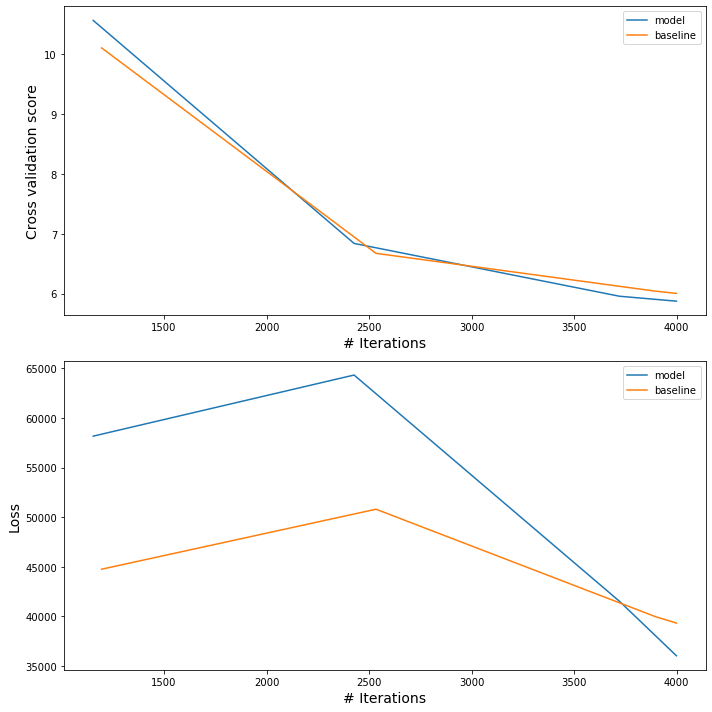

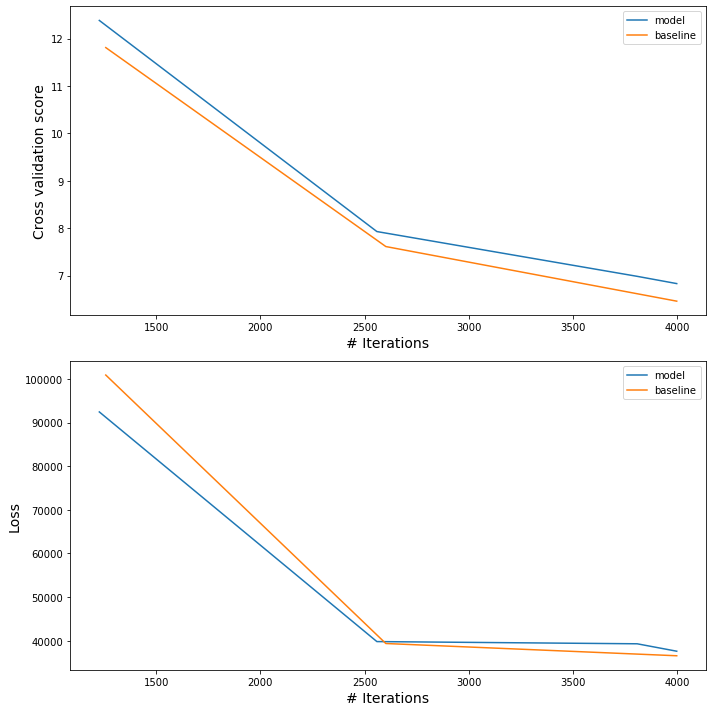

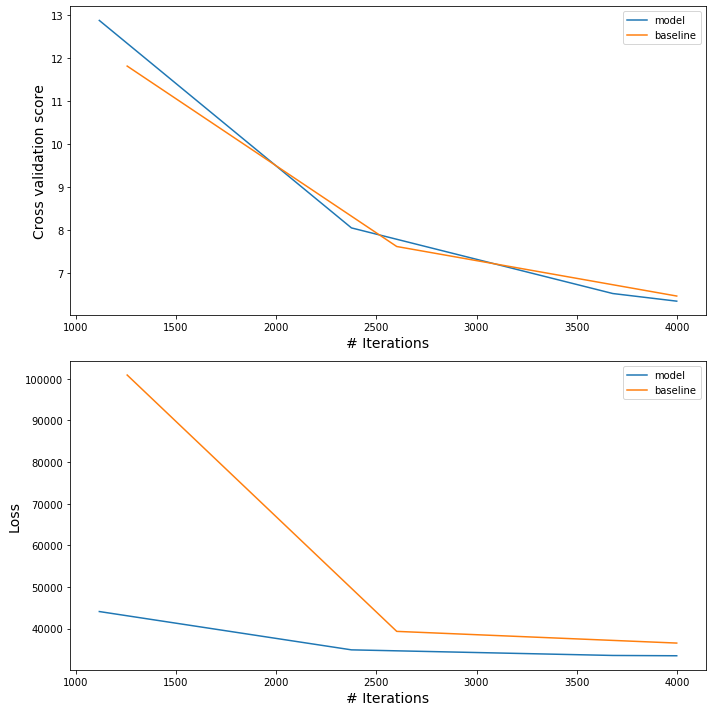

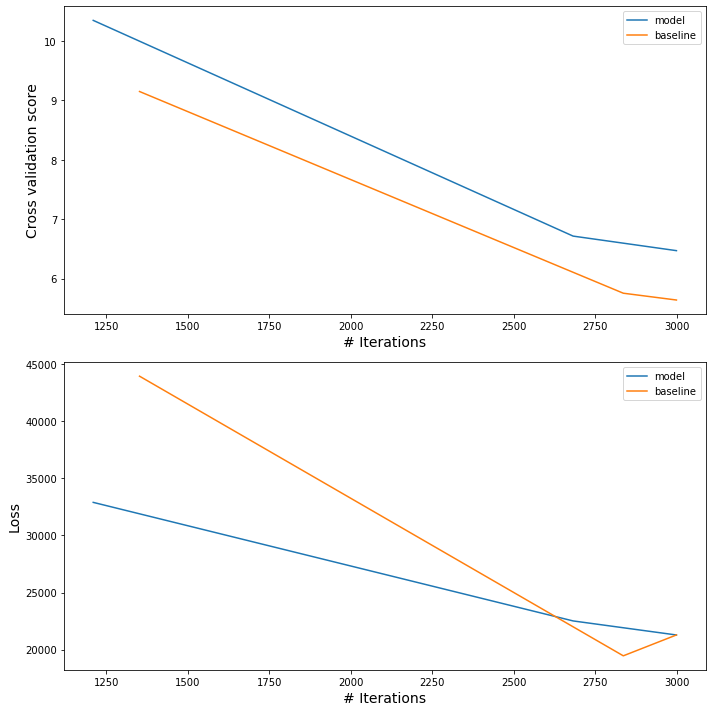

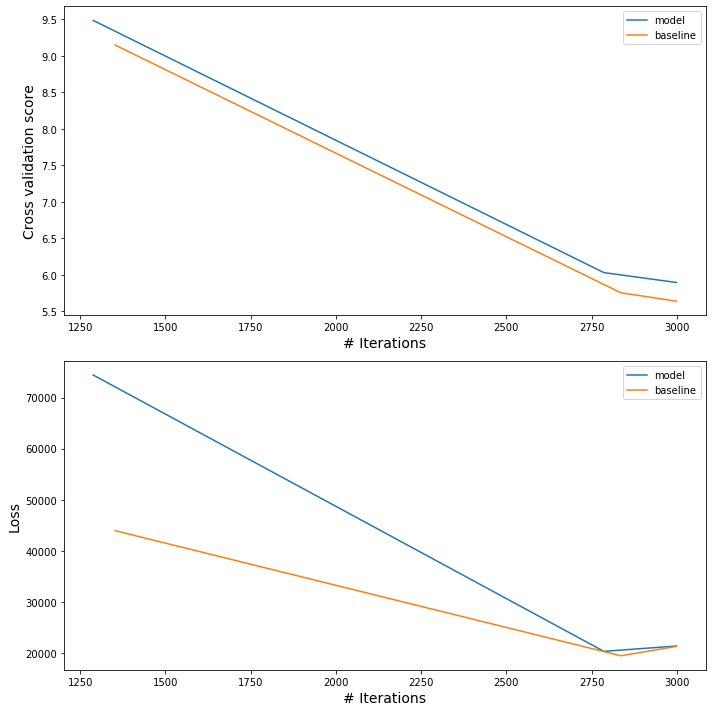

In [95]:
tensor_dict = {db:{} for db in dbs}
for db in dbs:
    for factor in ["t1d","weight"]:
        folder = "songbird/Metacyc2/{}/{}".format(db,factor)
        print(factor)
        tensor_dict[db][factor] = summarize_paired(regression_stats = songbird_dict[db][factor]["regression_stats"],
                                                           baseline_stats = songbird_dict[db]["null"]["regression_stats"]).visualization
        #Save output
        tensor_dict[db][factor].save(folder + "/model_fit_stats.qzv")

In [89]:
tensor_dict["enzyme"]["t1d"]

<visualization: Visualization uuid: ef1ed63f-669c-4c20-8ae8-a0c124632c3f>

In [11]:
dbs = ["protein","enzyme","reaction","pathway"]
name_file_dict = {"protein":"/projects/wol/20170307/release/annotation/metacyc/protein.names",
"enzyme":"/projects/wol/20170307/release/annotation/metacyc/enzrxn.names",
"reaction":"/projects/wol/20170307/release/annotation/metacyc/reaction.names",
"pathway":"/projects/wol/20170307/release/annotation/metacyc/pathway.names"}
names_conversion_dict = {db:{} for db in dbs}

for db in dbs:
    with open(name_file_dict[db]) as openfile:
        for line in openfile:
            linesplit = line.split()
            names_conversion_dict[db][linesplit[0]] = ' '.join(linesplit[1:])




In [12]:
differential_dict = {db:{} for db in dbs}

for db in dbs:
    for factor in ["t1d","weight"]:
        differentials_df = songbird_dict[db][factor]["differentials"].view(pd.DataFrame)
        #Add metabolite metadata
        #differentials_df = differentials_df.merge(md, right_index=True, left_index=True)
        sort_col = differentials_df.columns[1]
        differentials_df = differentials_df.sort_values(sort_col)
        differentials_df["name"] = [names_conversion_dict[db][x] if x in names_conversion_dict[db].keys() else '' for x in differentials_df.index]
        differential_dict[db][factor] = differentials_df

In [98]:
#Save differential dicts
for db in differential_dict.keys():
    for factor,df in differential_dict[db].items():
        folder = "songbird/Metacyc/{}/{}".format(db,factor)
        df.to_csv(folder + "/{}_{}_songbird_differentials.tsv".format(db, factor), sep='\t')

In [13]:
def top_bottom(df, n=10):
    #Function for viewing a table
    return df.head(n).append(df.tail(n)).style.bar(subset=df.columns[1], align='mid', color=['#00BFC4','#F8766D'])


In [14]:
top_bottom(differential_dict["protein"]["t1d"], n=8)

,Intercept,analysis_t1d[T.T1D],name
featureid,,,
MELB-MONOMER,0.141674,-2.20961,melibiose:H+/Na+/Li+ symporter
MONOMER-15684,-0.22645,-2.13416,bile salt hydrolase subunit
MONOMER-11591,0.122688,-1.51413,N6-hydroxylysine O-acetyltransferase subunit
ABGT-MONOMER,0.195299,-1.50838,p-aminobenzoyl glutamate:H+ symporter
3-ISOPROPYLMALDEHYDROG-MONOMER,-1.18759,-1.38059,3-isopropylmalate dehydrogenase
FHUC-MONOMER,-1.51884,-1.25411,iron(III) hydroxamate ABC transporter ATP binding subunit
G6644-MONOMER,0.209371,-1.16583,glutamate-putrescine ligase
EG11597-MONOMER,-1.64883,-1.14116,molybdopterin synthase sulfur carrier subunit
EG11237-MONOMER,0.248684,0.796149,endochitinase


In [15]:
top_bottom(differential_dict["enzyme"]["t1d"], n=8)

,Intercept,analysis_t1d[T.T1D],name
featureid,,,
ENZRXN-19295,0.938158,-1.4902,endo-α-N-acetylgalactosaminidase
ENZRXN0-8402,0.910622,-1.17729,D-alanyl-D-alanine carboxypeptidase
ENZRXN0-8329,-0.450078,-1.10315,protein deglycase
ENZRXN0-6288,-0.154407,-0.983191,D-malate dehydrogenase (decarboxylating)
MANNKIN-ENZRXN,-1.09176,-0.961585,mannokinase
ENZRXN0-250,-0.122872,-0.957527,propionyl-CoA:succinate CoA transferase
ENZRXN0-6274,-1.58375,-0.94774,3 methyl-adenine DNA glycosylase
ENZRXN0-6601,-0.312093,-0.895362,3-hydroxypropionaldehyde dehydrogenase
ENZRXN0-6220,-0.612218,0.709051,ADP-heptose:Kdo2-lipid A heptosyltransferase


In [53]:
top_bottom(differential_dict["reaction"]["t1d"], n=8)

,Intercept,analysis_t1d[T.T1D],name
featureid,,,
RXN-14092,0.618491,-1.40351,
PEPTIDYLPROLYL-ISOMERASE-RXN,-1.99396,-1.19596,
RXN0-6371,0.748018,-1.12515,
RXN-9778,1.84115,-1.12129,
3.2.1.97-RXN,0.621594,-1.08999,
RXN-17700,0.145393,-0.94518,
VAGL-RXN,-0.693905,-0.841572,
RXN0-5297,0.519777,-0.823216,
3.2.1.21-RXN,-0.01311,0.729224,


In [54]:
top_bottom(differential_dict["pathway"]["t1d"], n=8)

,Intercept,analysis_t1d[T.T1D],name
featureid,,,
PWY-7808,1.7466,-1.97068,tetracycline resistance
SUCUTIL-PWY,-0.513479,-1.6989,sucrose degradation I (sucrose phosphotransferase)
PWY-7884,1.44639,-1.50308,lipoprotein posttranslational modification
GLUDEG-I-PWY,0.181047,-1.35753,GABA shunt
PWY-4321,0.0104796,-1.07446,L-glutamate degradation IV
P345-PWY,0.246688,-0.986923,aldoxime degradation
PWY-2721,-0.427306,-0.909997,trehalose degradation III
P122-PWY,-1.23618,-0.900103,heterolactic fermentation
ECASYN-PWY,-0.58142,0.853981,enterobacterial common antigen biosynthesis


In [56]:
top_bottom(differential_dict["pathway"]["weight"], n=8)

,Intercept,analysis_weight_group[T.O],name
featureid,,,
PWY-7884,1.42298,-1.17033,lipoprotein posttranslational modification
PWY-7942,-0.496435,-1.15019,5-oxo-L-proline metabolism
PWY0-1534,-0.229891,-1.06782,hydrogen sulfide biosynthesis I
P345-PWY,0.105808,-0.940928,aldoxime degradation
PWY-6012-1,-0.345026,-0.925033,acyl carrier protein activation
PWY-6167,0.114683,-0.644121,flavin biosynthesis II (archaea)
PWY-2721,-0.895383,-0.597293,trehalose degradation III
PWY-6053,-0.0273746,-0.59095,dimethylsulfoniopropanoate biosynthesis III (algae)
PWY-881,-0.730752,0.705102,trehalose biosynthesis II


In [18]:
differential_dict["enzyme"]["t1d"]

,Intercept,analysis_t1d[T.T1D],name
featureid,,,
ENZRXN-19295,0.938158,-1.490201,endo-&alpha;-N-acetylgalactosaminidase
ENZRXN0-8402,0.910622,-1.177289,D-alanyl-D-alanine carboxypeptidase
ENZRXN0-8329,-0.450078,-1.103151,protein deglycase
ENZRXN0-6288,-0.154407,-0.983191,D-malate dehydrogenase (decarboxylating)
MANNKIN-ENZRXN,-1.091762,-0.961585,mannokinase
...,...,...,...
GPH-ENZRXN,-0.872376,0.783738,phosphoglycolate phosphatase
HOMOCYSMETB12-ENZRXN,0.571073,0.907098,methionine synthase
UDPNACETYLMURAMATEDEHYDROG-ENZRXN,-0.531204,0.913344,UDP-<i>N</i>-acetylenolpyruvoylglucosamine red...


# Try songbird with more complex formula

In [103]:
#Set up dictionaries
dbs = ["protein","enzyme","reaction","pathway"]
factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }
#songbird_dict = {db:{"t1d":{},"weight":{},"null":{}} for db in dbs}

def b2q(bt):
    return(q2.Artifact.import_data('FeatureTable[Frequency]',bt))

#Run/Import Songbird


(temp_differentials,
 temp_regression_stats,
 temp_regression_biplot) = multinomial(table=b2q(biom_dict["protein"]),
                                       metadata=qza_md,
                                       formula='analysis_t1d + analysis_weight_group',
                                       summary_interval=1)


        

100%|██████████| 5000/5000 [00:05<00:00, 961.37it/s] 


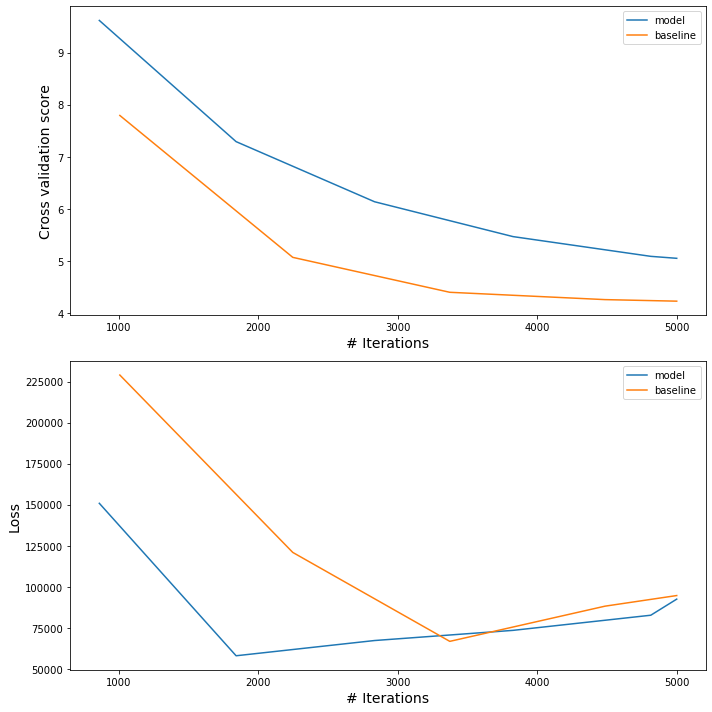

In [104]:
#Check model fit
db="protein"

tensor_dict[db][factor] = summarize_paired(regression_stats = temp_regression_stats,
                                                   baseline_stats = songbird_dict[db]["null"]["regression_stats"]).visualization
#Save output
#tensor_dict[db][factor].save(folder + "/model_fit_stats.qzv")

In [105]:
db="protein"

differentials_df = temp_differentials.view(pd.DataFrame)
#Add metabolite metadata
#differentials_df = differentials_df.merge(md, right_index=True, left_index=True)
sort_col = differentials_df.columns[1]
differentials_df = differentials_df.sort_values(sort_col)
differentials_df["name"] = [names_conversion_dict[db][x] if x in names_conversion_dict[db].keys() else '' for x in differentials_df.index]
#differential_dict[db][factor] = differentials_df

In [106]:
differentials_df

,Intercept,analysis_t1d[T.T1D],analysis_weight_group[T.O],name
featureid,,,,
MELB-MONOMER,0.189501,-2.247644,-0.070473,melibiose:H<sup>+</sup>/Na<sup>+</sup>/Li<sup>...
MONOMER-15684,-0.418597,-2.023507,0.750727,bile salt hydrolase subunit
ABGT-MONOMER,0.278097,-1.525941,-0.585884,<i>p</i>-aminobenzoyl glutamate:H<sup>+</sup> ...
MONOMER-11591,0.216268,-1.515938,-0.954125,N<sup>6</sup>-hydroxylysine <i>O</i>-acetyltra...
3-ISOPROPYLMALDEHYDROG-MONOMER,-1.105163,-1.433830,-0.374587,3-isopropylmalate dehydrogenase
...,...,...,...,...
LCTP-MONOMER,-0.419442,1.103942,0.560386,lactate/glycolate:H<sup>+</sup> symporter LldP
EG10746-MONOMER,0.109048,1.272763,0.699433,DNA polymerase I
EG10302-MONOMER,-0.989567,1.341956,0.856584,ferrichrome outer membrane transporter/phage r...
